In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

In [2]:
facebook = pd.read_csv(
    "data/facebook_combined.txt",
    sep=" ",
    names=["start_node", "end_node"],
)

In [3]:
facebook.head(10)

,start_node,end_node
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
5,0,6
6,0,7
7,0,8
8,0,9
9,0,10


In [4]:
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")

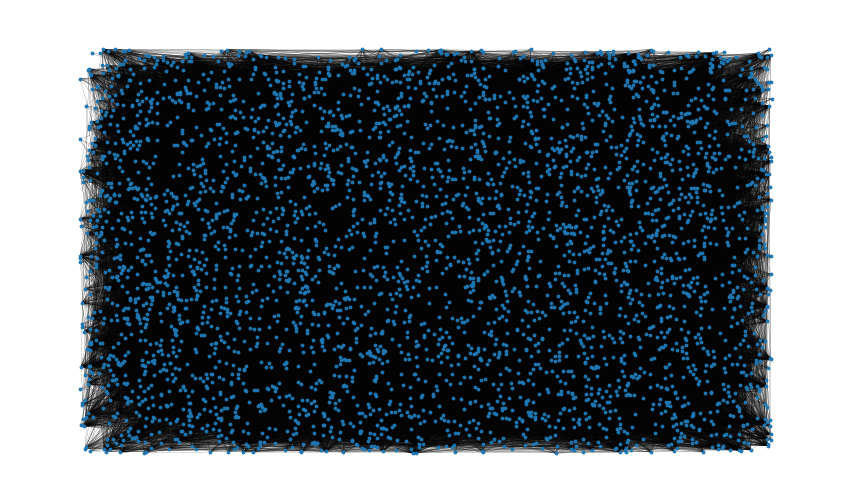

In [5]:
# 使用random layout 可视化数据，这是布局最快的函数但是难以观察数据的结构
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_settings = {"node_size": 8,  "width": 0.15, "with_labels": False}
alpha = 0.5
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_settings)

使用spring_layout函数，spring_layout函数是networkx绘图模块的默认布局函数。spring_layout会考虑节点和边来计算节点位置，比起random_layout,此函数更能够反应社交网络的结构。不过其计算时间也相对更多。

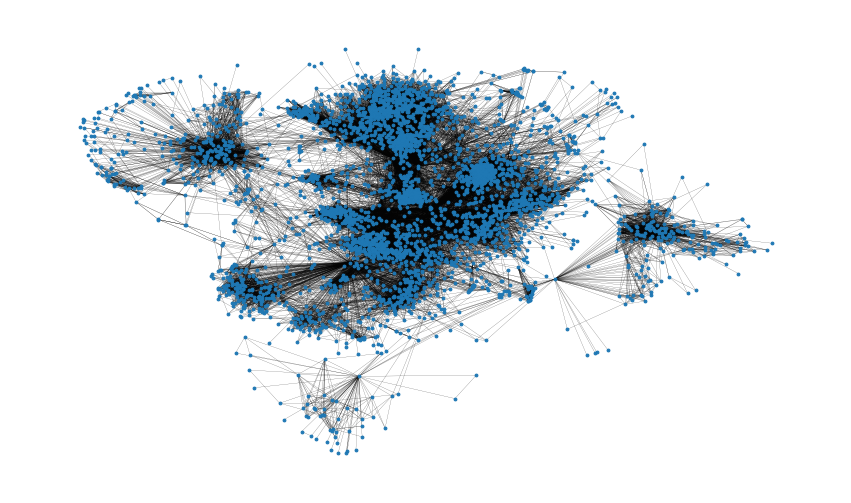

In [6]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
# 此处seed的取值比较多样，可以选择更能展示网络结构的参数
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_settings)

接下来我们可以看一些网络的基础信息，如：节点数量，连边数量等等。

In [7]:
nodes = G.number_of_nodes()# 节点数量
print("Number of nodes in the graph:", nodes)

Number of nodes in the graph: 4039


In [8]:
edges = G.number_of_edges()# 连边数量
print("Number of edges in the graph:", edges)

Number of edges in the graph: 88234


In [9]:
mean_degree = np.mean([degree for node, degree in G.degree()])
print("Mean degree of nodes in the graph:", mean_degree)

Mean degree of nodes in the graph: 43.69101262688784


In [10]:
density = nx.density(G)
print("Density of graph:", density)

Density of graph: 0.010819963503439287


In [11]:
diameter = nx.diameter(G)
print("The diameter of the graph:", diameter)

The diameter of the graph: 8


In [12]:
shortest_among_nodes = dict(nx.all_pairs_shortest_path_length(G))
# Compute the mean shortest path length for each node
# 这里的shortest_among_nodes记录了每个nodes到其他所有node所需要的最短路径
# 两次平均就可以求得任意两个nodes之间的平均距离
mean_len_each_node = [
    np.mean(tuple(anode.values())) for anode in shortest_among_nodes.values()
]
# The average over all nodes
mean_among_all_nodes = np.mean(mean_len_each_node)
print("The average length among all nodes is:", mean_among_all_nodes)

The average length among all nodes is: 3.691592636562027


<BarContainer object of 9 artists>

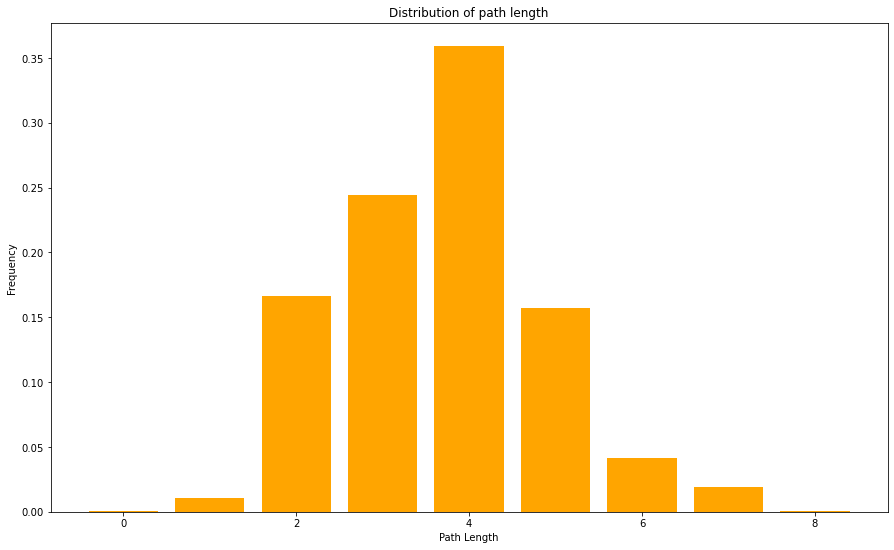

In [13]:
counts = np.zeros(diameter + 1, dtype=int)

for item in shortest_among_nodes.values():
    values_len = item.values()
    index, times = np.unique(list(values_len), return_counts=True)
    counts[index] += times

fre_counts = counts/np.sum(counts)
fig,ax = plt.subplots(figsize=(15,9))
ax.set_title("Distribution of path length")
ax.set_xlabel("Path Length")
ax.set_ylabel("Frequency")
ax.bar(np.arange(0, diameter+1), height = fre_counts,color = 'orange')

## 接下来我们进行一些关于度中心性的计算
### 1.首先是degree centrality

In [14]:
degree = nx.centrality.degree_centrality(G)  
degree_10 = (sorted(degree.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", degree_10)

Max 10:
 [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317), (1800, 0.06067360079247152), (1663, 0.058197127290737984)]


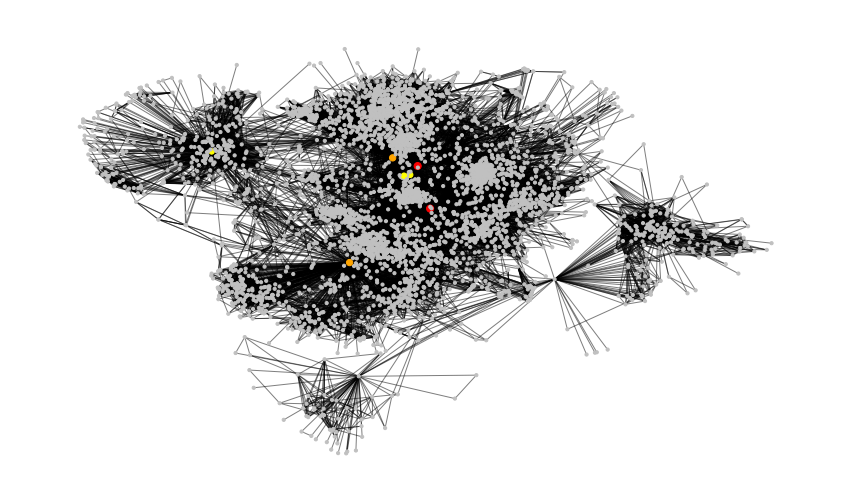

In [15]:
# 可视化
max_degree = max(np.max(degree.values()))
highlight = []
nodes_size = []
for key, value in degree.items():
    if value > max_degree*0.75:
        highlight.append('red')
        nodes_size.append(50)
    elif value > max_degree*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_degree*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

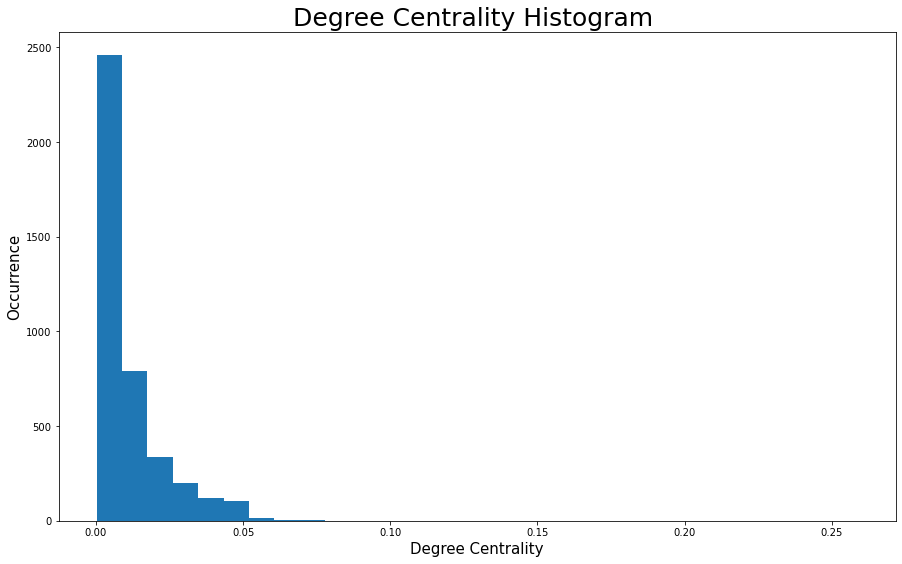

In [16]:
plt.subplots(figsize=(15, 9))
plt.hist(degree.values(), bins=30)
plt.title("Degree Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 2.Eigenvector centrality

In [17]:
eig = nx.centrality.eigenvector_centrality(G)  
eig_10 = (sorted(degree.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", eig_10)

Max 10:
 [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317), (1800, 0.06067360079247152), (1663, 0.058197127290737984)]


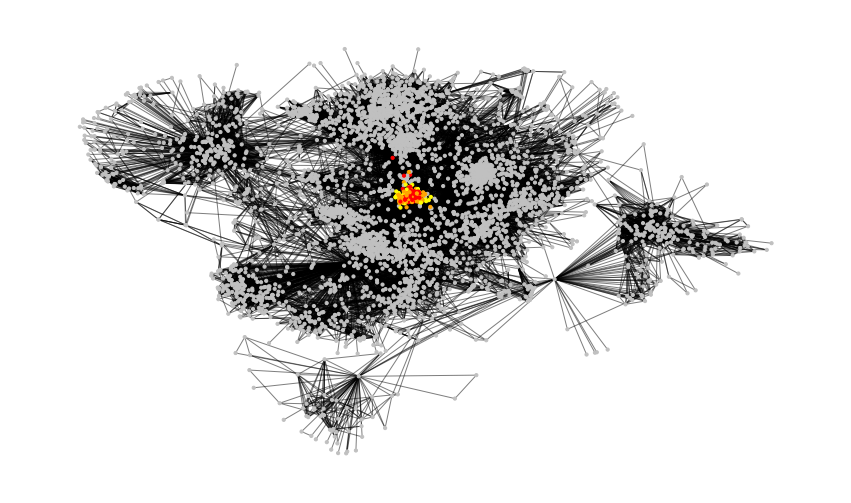

In [18]:
# 可视化
max_eig = max(np.max(eig.values()))
highlight = []
nodes_size = []
for key, value in eig.items():
    if value > max_eig*0.75:
        highlight.append('red')
        nodes_size.append(10) # 由于eig值大的点比较聚集，因此不用突出显示
    elif value > max_eig*0.5:
        highlight.append("orange")
        nodes_size.append(10)
    elif value > max_eig*0.25:
        highlight.append('yellow')
        nodes_size.append(10)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

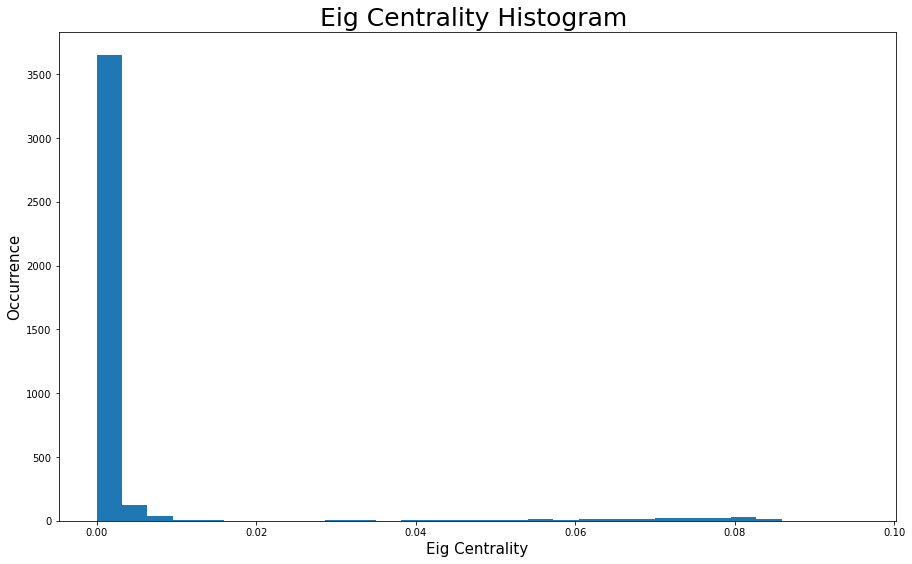

In [19]:
plt.subplots(figsize=(15, 9))
plt.hist(eig.values(), bins=30)
plt.title("Eig Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Eig Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 3.Katz Centrality

In [20]:
katz = nx.centrality.degree_centrality(G)  
katz_10 = (sorted(katz.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", katz_10)

Max 10:
 [(107, 0.258791480931154), (1684, 0.1961367013372957), (1912, 0.18697374938088163), (3437, 0.13546310054482416), (0, 0.08593363051015354), (2543, 0.07280832095096582), (2347, 0.07206537890044576), (1888, 0.0629024269440317), (1800, 0.06067360079247152), (1663, 0.058197127290737984)]


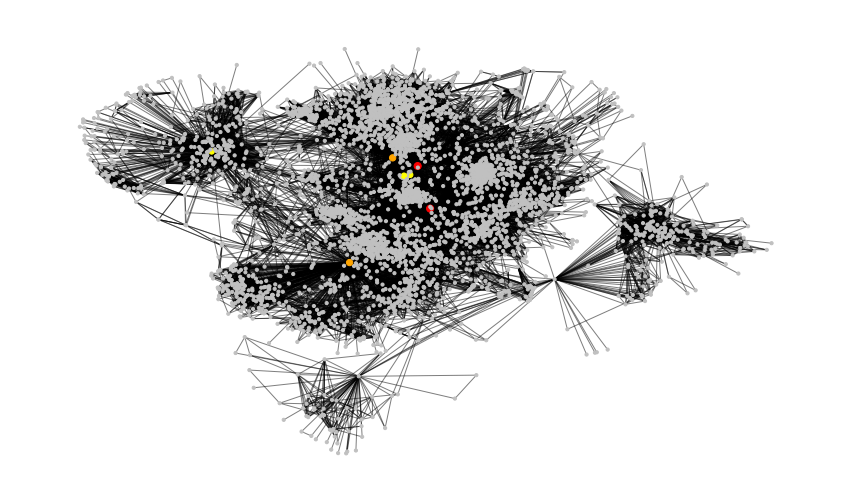

In [21]:
# 可视化
max_katz = max(np.max(katz.values()))
highlight = []
nodes_size = []
for key, value in katz.items():
    if value > max_katz*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_katz*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_katz*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)    

Text(0, 0.5, 'Occurrence')

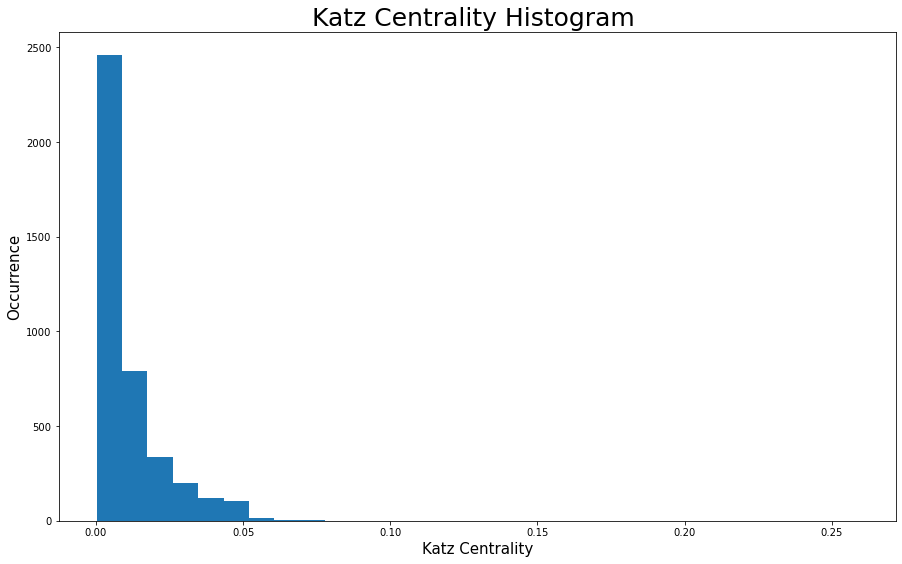

In [22]:
plt.subplots(figsize=(15, 9))
plt.hist(katz.values(), bins=30)
plt.title("Katz Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Katz Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 4. PageRank Centrality

In [23]:
page = nx.pagerank(G, alpha=0.8)  
page_10 = (sorted(page.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", page_10)

Max 10:
 [(3437, 0.007584744098079048), (107, 0.007061630885680768), (1684, 0.006402276277726099), (0, 0.006374181489249572), (1912, 0.00395967705766882), (348, 0.0023874213527862115), (686, 0.002202766494586254), (3980, 0.002158620580633203), (414, 0.001849015216377652), (698, 0.0013398147414446625)]


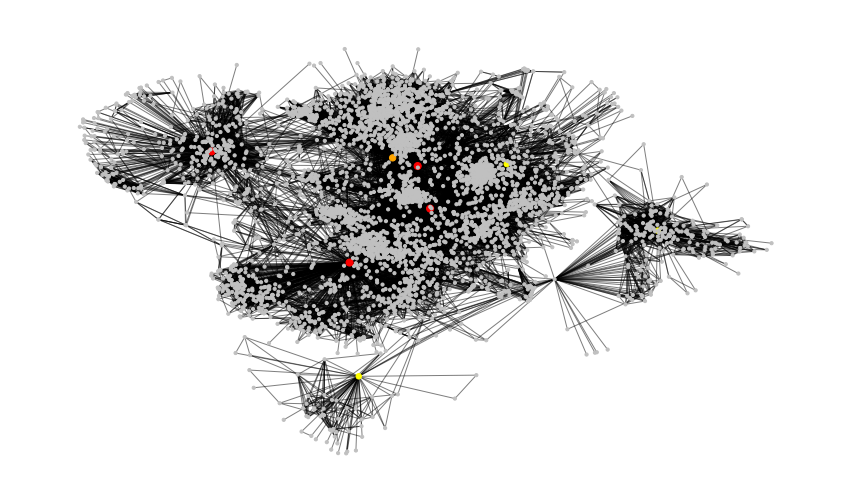

In [24]:
# 可视化
max_page = max(np.max(page.values()))
highlight = []
nodes_size = []
for key, value in page.items():
    if value > max_page*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_page*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_page*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

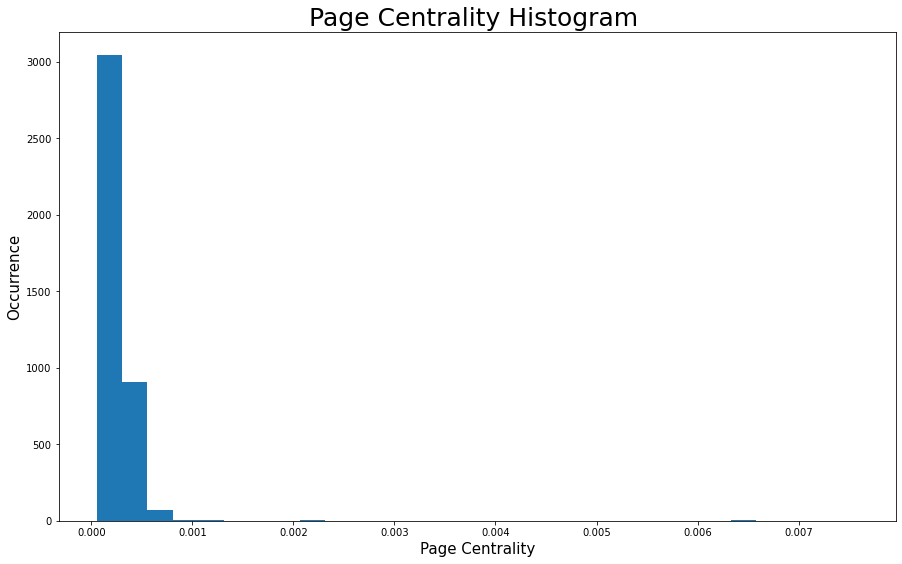

In [25]:
plt.subplots(figsize=(15, 9))
plt.hist(page.values(), bins=30)
plt.title("Page Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Page Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 5. Betweenness Centrality

In [26]:
between = nx.centrality.betweenness_centrality(G)  
between_10 = (sorted(between.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", between_10)

Max 10:
 [(107, 0.4805180785560152), (1684, 0.3377974497301992), (3437, 0.23611535735892905), (1912, 0.2292953395868782), (1085, 0.14901509211665306), (0, 0.14630592147442917), (698, 0.11533045020560802), (567, 0.09631033121856215), (58, 0.08436020590796486), (428, 0.06430906239323866)]


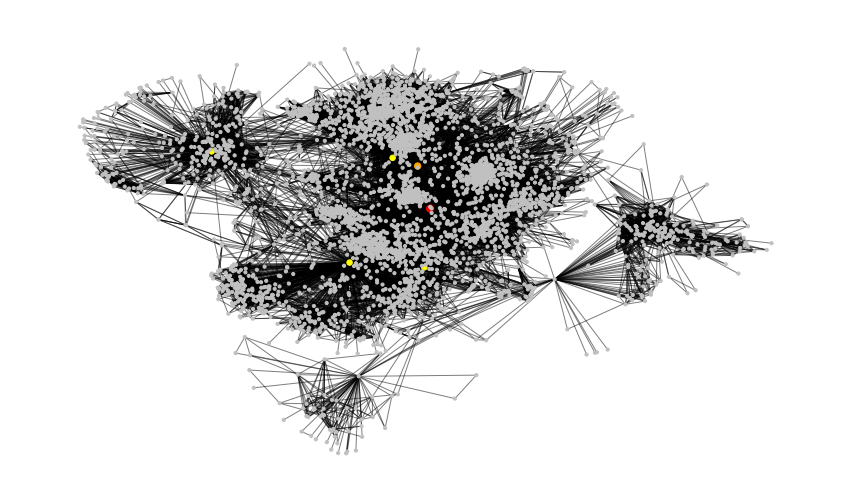

In [27]:
# 可视化
max_between = max(np.max(between.values()))
highlight = []
nodes_size = []
for key, value in between.items():
    if value > max_between*0.75:
        highlight.append('red')
        nodes_size.append(50) 
    elif value > max_between*0.5:
        highlight.append("orange")
        nodes_size.append(40)
    elif value > max_between*0.25:
        highlight.append('yellow')
        nodes_size.append(30)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

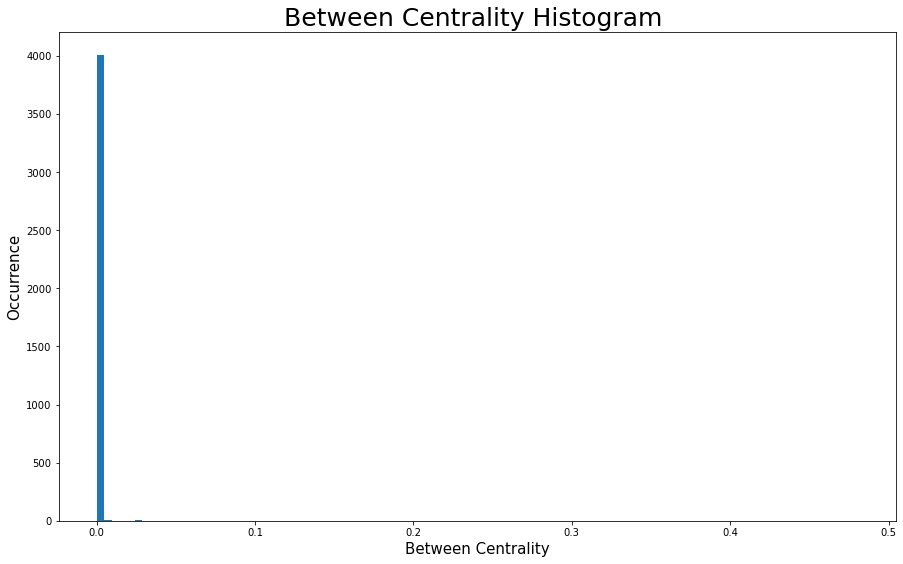

In [28]:
plt.subplots(figsize=(15, 9))
plt.hist(between.values(), bins=100)
plt.title("Between Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Between Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})

### 6. Closeness centrality

In [29]:
close = nx.centrality.closeness_centrality(G)  
close_10 = (sorted(close.items(), key=lambda x: x[1], reverse=True))[:10]
print("Max 10:\n", close_10)

Max 10:
 [(107, 0.45969945355191255), (58, 0.3974018305284913), (428, 0.3948371956585509), (563, 0.3939127889961955), (1684, 0.39360561458231796), (171, 0.37049270575282134), (348, 0.36991572004397216), (483, 0.3698479575013739), (414, 0.3695433330282786), (376, 0.36655773420479304)]


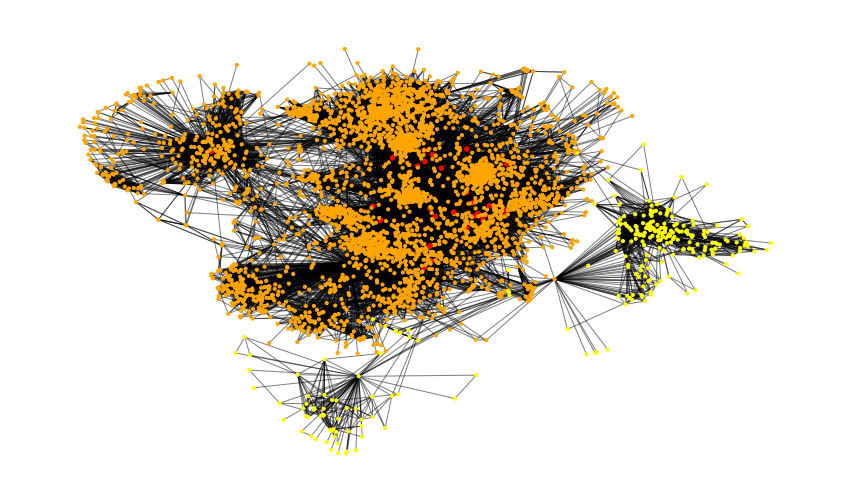

In [30]:
# 可视化
max_close = max(np.max(close.values()))
highlight = []
nodes_size = []
for key, value in close.items():
    if value > max_close*0.75:
        highlight.append('red')
        nodes_size.append(20) 
    elif value > max_close*0.5:
        highlight.append("orange")
        nodes_size.append(10)
    elif value > max_close*0.25:
        highlight.append('yellow')
        nodes_size.append(10)
    else:
        highlight.append("Silver")
        nodes_size.append(10)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx_nodes(G, pos=pos, ax=ax, node_size = nodes_size, node_color = highlight)
nx.draw_networkx_edges(G, pos=pos, alpha = alpha)  

Text(0, 0.5, 'Occurrence')

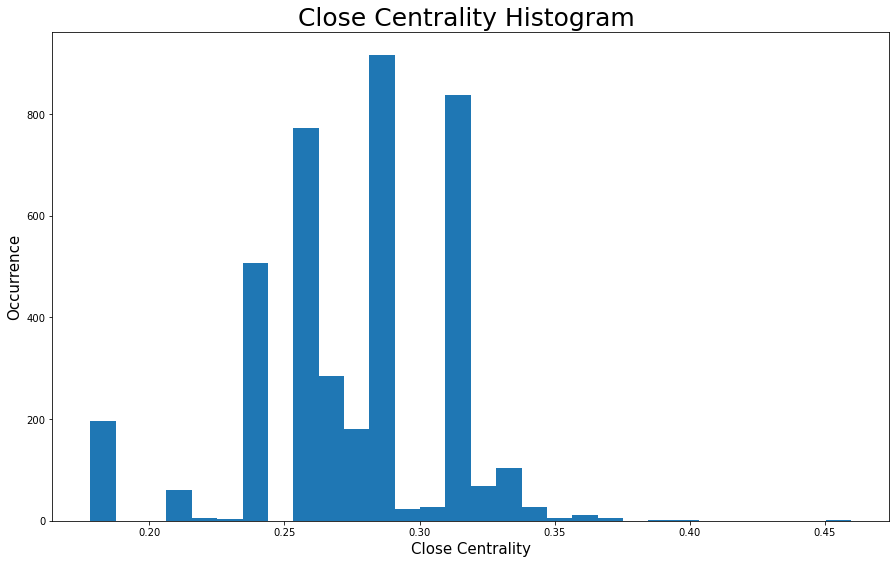

In [31]:
plt.subplots(figsize=(15, 9))
plt.hist(close.values(), bins=30)
plt.title("Close Centrality Histogram ", fontdict={"size": 25}, loc="center")
plt.xlabel("Close Centrality", fontdict={"size": 15})
plt.ylabel("Occurrence", fontdict={"size": 15})